# Probabilistic Algorithms

## Traveling Salesman Problem

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import pandas as pd
import numpy as np
import scipy.spatial as sp
from tsp.tsp import TravelingSalesmanProblem
import tsp.tsp_heuristic as th

from matplotlib import pyplot as plt

In [3]:
nodes = pd.read_csv("TSP_411.txt", sep='\s+', names=['node', 'x', 'y'])

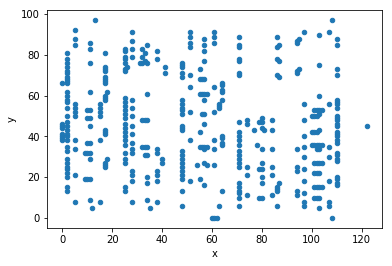

In [4]:
nodes.plot(kind='scatter', x='x',y='y')

In [159]:
tsp = TravelingSalesmanProblem(nodes)

In [160]:
bestinsert = th.BestInsertion(tsp)

In [162]:
bestinsert.calculate_tour()

In [188]:
from matplotlib import collections as mc

def build_plot(heuristic_result):
    plt.rcParams['figure.figsize'] = (14, 9)
    start = heuristic_result.get_starting_node_for_plotting()
    x, y = np.array(heuristic_result.get_tour_for_plotting()).T
    plt.plot(x, y)
    plt.plot(start[0],start[1],"ro")
    plt.title("Distance travelled: {}".format(heuristic_result.length))
    plt.axis('off')
    plt.show()

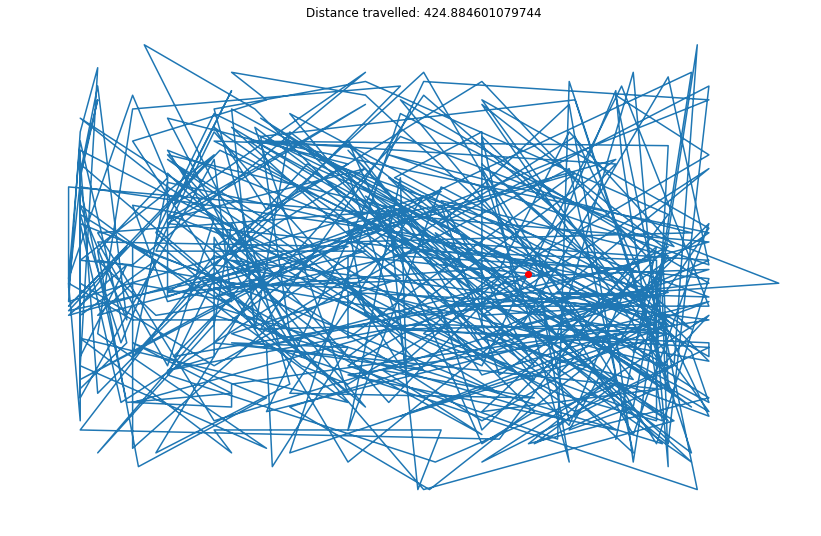

In [189]:
build_plot(bestinsert)

### Best-Best Insertion

In [190]:
bbinsert = th.BestBestInsertion(tsp)

In [192]:
bbinsert.calculate_tour()

Available nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 21

IndexError: list index out of range

In [ ]:
build_plot(bbinsert.tour,bbinsert.length)